In [2]:
# Import necessary libraries
import pandas as pd

# Load the dataset
df = pd.read_excel("Online Retail.xlsx")

# Display first few rows
print(df.head())


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [3]:
# Basic structure of the dataset
df.info()

# Check for missing values
df.isnull().sum()

# Quick summary
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [13]:
# Data Cleaning
# Remove rows with missing CustomerID
df = df[df['CustomerID'].notnull()]

# Remove negative or zero Quantity and UnitPrice
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Remove credit transactions (returns)
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Drop duplicates
df = df.drop_duplicates()

# Check updated data
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 392692 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  int32         
 7   Country      392692 non-null  object        
 8   TotalPrice   392692 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(4)
memory usage: 28.5+ MB


In [14]:
# RFM Features
# Convert CustomerID to int
df['CustomerID'] = df['CustomerID'].astype(int)

# Create TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Latest date in the dataset to calculate recency
import datetime as dt
latest_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# RFM table
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,   # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalPrice': 'sum'                                       # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Show top few records
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12347,2,7,4310.00
2,12348,75,4,1797.24
3,12349,19,1,1757.55
4,12350,310,1,334.40


In [15]:
# K-Means clustering uses Euclidean distance, scaling the Recency, Frequency, and Monetary values using StandardScaler

from sklearn.preprocessing import StandardScaler

# Features for clustering
features = rfm[['Recency', 'Frequency', 'Monetary']]

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the data
scaled_features = scaler.fit_transform(features)

# Convert back to a DataFrame (optional, for readability)
scaled_df = pd.DataFrame(scaled_features, columns=['Recency', 'Frequency', 'Monetary'])

# Check scaled data
scaled_df.head()


,Recency,Frequency,Monetary
0,2.334574,-0.425097,8.363010
1,-0.905340,0.354417,0.251699
2,-0.175360,-0.035340,-0.027988
3,-0.735345,-0.425097,-0.032406
4,2.174578,-0.425097,-0.190812


In [16]:
# Appling K-Means Clustering

from sklearn.cluster import KMeans

# Apply KMeans with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(scaled_df)

# Check first few rows with assigned clusters
rfm.head()


,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346,326,1,77183.60,3
1,12347,2,7,4310.00,0
2,12348,75,4,1797.24,0
3,12349,19,1,1757.55,0
4,12350,310,1,334.40,1


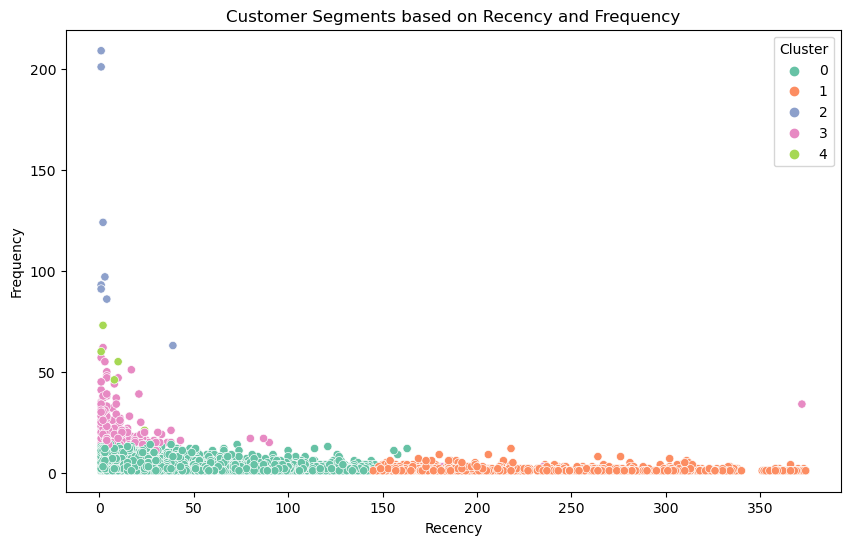

In [17]:
# Visualize the Clusters
# A. Recency vs. Frequency

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Cluster', palette='Set2')
plt.title('Customer Segments based on Recency and Frequency')
plt.show()


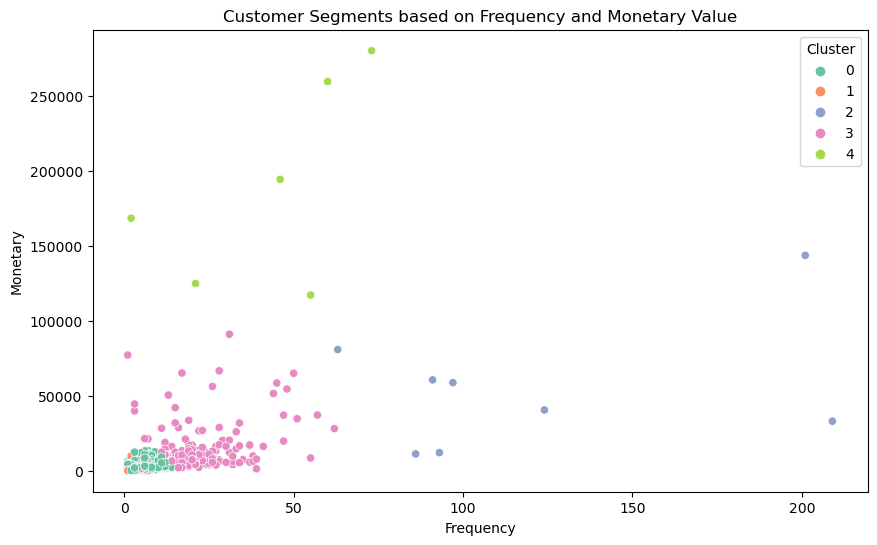

In [21]:
# B. Frequency vs. Monetary

plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Cluster', palette='Set2')
plt.title('Customer Segments based on Frequency and Monetary Value')
plt.show()


In [10]:
# Average RFM per cluster
cluster_summary = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(1)
cluster_summary


,Recency,Frequency,Monetary
Cluster,,,
0,43.9,3.7,1333.1
1,248.5,1.6,478.6
2,6.5,120.5,55099.5
3,15.7,21.3,12813.9
4,7.7,42.8,190808.5


In [23]:
# Labeling Clusters
# Manually assign labels (adjust according to your actual cluster means)
cluster_labels = {
    0: 'Champions',
    1: 'At Risk',
    2: 'Lost Customers',
    3: 'Potential Loyalist',
    4: 'New Customers'
}

# Apply labels
rfm['Segment'] = rfm['Cluster'].map(cluster_labels)

# View labeled segments
rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Cluster', 'Segment']].head()


,CustomerID,Recency,Frequency,Monetary,Cluster,Segment
0,12346,326,1,77183.60,3,Potential Loyalist
1,12347,2,7,4310.00,0,Champions
2,12348,75,4,1797.24,0,Champions
3,12349,19,1,1757.55,0,Champions
4,12350,310,1,334.40,1,At Risk


In [24]:
# Cluster summary statistics
rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)


Recency Frequency  Monetary      
           mean      mean      mean count
Cluster                                  
0          43.9       3.7    1333.1  3048
1         248.5       1.6     478.6  1063
2           6.5     120.5   55099.5     8
3          15.7      21.3   12813.9   213
4           7.7      42.8  190808.5     6

In [12]:
!pip install streamlit
